In [1]:
# Load dependencies
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
from scipy.optimize import curve_fit
from scipy.stats import norm, skewnorm

In [2]:
# Load filesizes data
fs=pd.read_csv('filesizes.csv')

In [3]:
# Remove files with zero size, create a log_2 x axis for fitting etc
fs = fs[fs['bytes'] > 0]
fs['bytes_log'] = np.log2(fs['bytes'])

In [4]:
# Calculate the number of files in total, create probability distribution function and cumulative distribution function for file numbers
n_files = fs['n'].sum()
fs['n_pdf'] = fs['n']/n_files
fs['n_cdf'] = fs['n'].cumsum()/n_files

In [5]:
# Fit a gaussian cumulative distribution function to file number cdf
initial_guess = [5.0, 10.0]

fit_params = curve_fit(norm.cdf, fs['bytes_log'], fs['n_cdf'], p0=initial_guess)[0]

In [6]:
# Create fits for cumulative distribution function and probability distribution function
fs['fit_cdf'] = norm.cdf(fs['bytes_log'], *fit_params)
fs['fit_pdf'] = norm.pdf(fs['bytes_log'], *fit_params)
fs['fit'] = n_files*fs['fit_pdf']
fit_mean = norm.stats(*fit_params, moments='m')

In [7]:
# Find median for cumulative distribution function
median_ix = np.argmax(fs['n_cdf'] > 0.5)+1
median = fs['bytes'][median_ix]

# Find three thirds
two_thirds_ix = np.argmax(fs['n_cdf'] > 0.66)+1
two_thirds = fs['bytes'][two_thirds_ix]

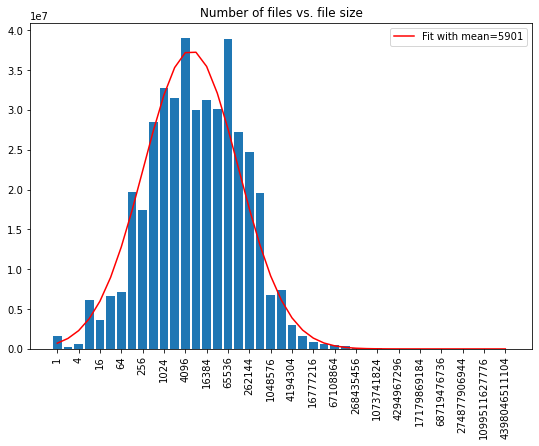

In [8]:
# Plot number of files (density) vs file size
f = mpl.figure(figsize=(9,6))
ax = mpl.gca()
ax.bar(fs['bytes_log'],fs['n'], width=0.8)
ax.plot(fs['bytes_log'], fs['fit'], 'r-', label='Fit with mean=%.f' % np.power(2.0, fit_mean))
mpl.title('Number of files vs. file size')
mpl.xticks(fs['bytes_log'][::2], fs['bytes'][::2])
mpl.xticks(rotation=90)
mpl.legend(loc=1)
mpl.savefig('filesizes.png')

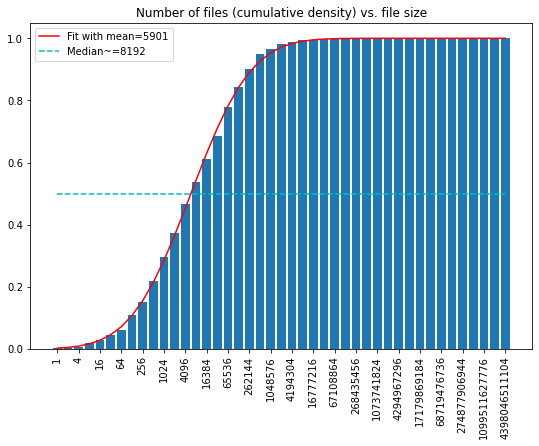

In [9]:
# Plot number of files (cdf) vs file size
f = mpl.figure(figsize=(9,6))
ax = mpl.gca()
ax.bar(fs['bytes_log'],fs['n_cdf'], width=0.8)
ax.plot(fs['bytes_log'],fs['fit_cdf'], 'r-', label='Fit with mean=%.f' % np.power(2.0, fit_mean))
ax.plot(fs['bytes_log'],0.5*np.ones_like(fs['bytes_log']), 'c--', label='Median~=%d' % median)
mpl.title('Number of files (cumulative density) vs. file size')
mpl.xticks(fs['bytes_log'][::2], fs['bytes'][::2])
mpl.xticks(rotation=90)
mpl.legend(loc=0)
mpl.savefig('filesizes_cdf.png')

In [10]:
# Get actual file size usage in GB
fs['usage'] = (fs['n']*fs['bytes'])/1e9
# Total files usage
usage_total = fs['usage'].sum()
# PDF and CDF
fs['usage_pdf'] = fs['usage']/usage_total
fs['usage_cdf'] = fs['usage'].cumsum()/usage_total

In [11]:
# Fit a skewed gaussian cumulative distribution function to file size usage cdf
initial_guess = [0.0, 20.0, 5.0]

fit_usage_params = curve_fit(skewnorm.cdf, fs['bytes_log'], fs['usage_cdf'], p0=initial_guess)[0]

In [12]:
# Create fits for cumulative distribution function and probability distribution function
fs['usage_fit_cdf'] = skewnorm.cdf(fs['bytes_log'], *fit_usage_params)
fs['usage_fit_pdf'] = skewnorm.pdf(fs['bytes_log'], *fit_usage_params)
fs['usage_fit'] = usage_total*fs['usage_fit_pdf']
usage_mean = skewnorm.stats(*fit_usage_params, moments='m')

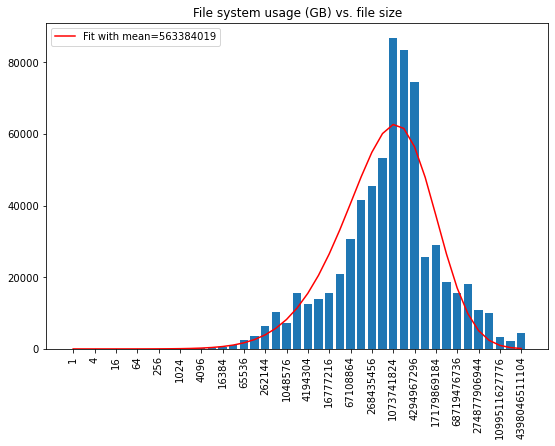

In [13]:
# Plot file system usage vs. file size
f = mpl.figure(figsize=(9,6))
ax = mpl.gca()
ax.bar(fs['bytes_log'],fs['usage'], width=0.8)
ax.plot(fs['bytes_log'],fs['usage_fit'], 'r-', label='Fit with mean=%.f' % np.power(2.0,usage_mean))
mpl.title('File system usage (GB) vs. file size')
mpl.xticks(fs['bytes_log'][::2], fs['bytes'][::2])
mpl.xticks(rotation=90)
mpl.legend(loc=0)
mpl.savefig('usage.png')

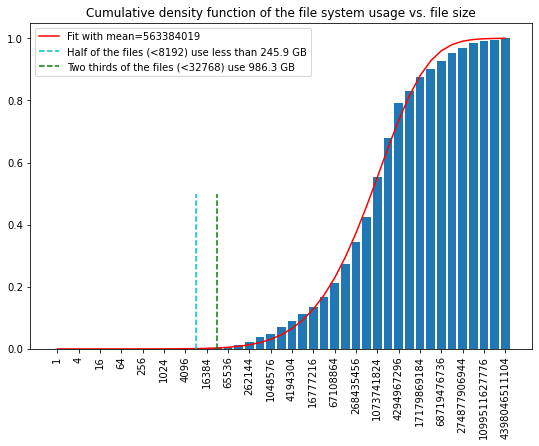

In [14]:
# Plot cumulative density function of the file system usage vs. file size

f = mpl.figure(figsize=(9,6))
ax = mpl.gca()
ax.bar(fs['bytes_log'],fs['usage_cdf'], width=0.8)
ax.plot(fs['bytes_log'],fs['usage_fit_cdf'], 'r-', label='Fit with mean=%.f' % np.power(2.0,usage_mean))
# Plot a line to show where halfway point is for file numbers
ax.plot(fs['bytes_log'][median_ix]*np.ones(2),[0.0,0.5], 'c--', label='Half of the files (<%d) use less than %.1f GB' % (median, fs['usage'][median_ix]))
# Plot a line to show where two-thirds point is for file numbers
ax.plot(fs['bytes_log'][two_thirds_ix]*np.ones(2),[0.0,0.5], 'g--', label='Two thirds of the files (<%d) use %.1f GB' % (two_thirds, fs['usage'][two_thirds_ix]))
mpl.title('Cumulative density function of the file system usage vs. file size')
mpl.xticks(fs['bytes_log'][::2], fs['bytes'][::2])
mpl.xticks(rotation=90)
mpl.legend(loc=0)
mpl.savefig('usage_cdf.png')

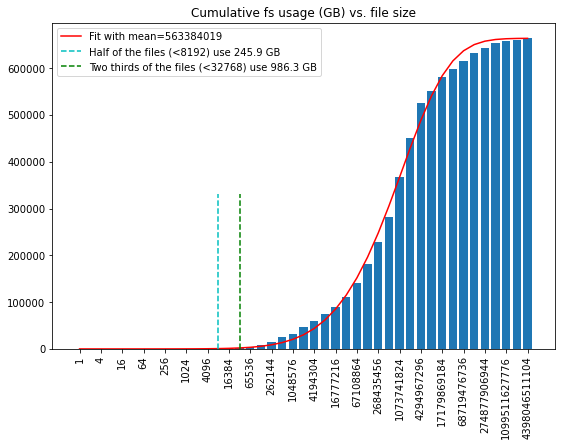

In [15]:
# Plot cumulative file system usage vs. file size
f = mpl.figure(figsize=(9,6))
ax = mpl.gca()

ax.bar(fs['bytes_log'],usage_total*fs['usage_cdf'], width=0.8)
ax.plot(fs['bytes_log'],usage_total*fs['usage_fit_cdf'], 'r-', label='Fit with mean=%.f' % np.power(2.0,usage_mean))
# Plot a line to show where halfway point is for file numbers
ax.plot(fs['bytes_log'][median_ix]*np.ones(2),[0.0,0.5*usage_total], 'c--', label='Half of the files (<%d) use %.1f GB' % (median, fs['usage'][median_ix]))
# Plot a line to show where two-thirds point is for file numbers
ax.plot(fs['bytes_log'][two_thirds_ix]*np.ones(2),[0.0,0.5*usage_total], 'g--', label='Two thirds of the files (<%d) use %.1f GB' % (two_thirds, fs['usage'][two_thirds_ix]))
mpl.title('Cumulative fs usage (GB) vs. file size')
mpl.xticks(fs['bytes_log'][::2], fs['bytes'][::2])
mpl.xticks(rotation=90)
mpl.legend(loc=0)
mpl.savefig('usage_cumulative.png')